<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/wayuu/COMP_ND.csv')
print(trans_df.shape)
print(trans_df.columns)

(8939, 2)
Index(['esp', 'wayuu'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

esp  \
6110  y ya nadie se atrevia a hacerle mas preguntas....   
2312  esta es precisamente mi defensa frente a mis d...   
7808  porque estuve hambriento, y ustedes me dieron ...   
4680  jesus les contesto   la doctrina que yo enseno...   
7772  pero si otro criado es malo y piensa en su int...   

                                                  wayuu  
6110  mmoluinapa joo na saduceokana je na wayuukana ...  
2312  anuu tu takujakat ne'ipajee na mojukana anuiki...  
7808  teenakuin jia suka jiainkain ekiruin taya wana...  
4680  numakalaka jesus namuin   tu tekirajakat anain...  
7772    jama muleka nnojorule juujuuin nia sumuin nu...

In [7]:
df_dev.head()

esp  \
1044  cuando llego el tiempo del parto, habia melliz...   
6839  ha hecho lo que estaba en su mano preparando p...   
6972  ozias, de joatan  joatan, de ajaz, y ajaz lo f...   
8032  pues los ojos del senor se fijan en los buenos...   
8406  que el dios de la esperanza llene de alegria y...   

                                                  wayuu  
1044  shiasa'a kettaapa tamar supula kachonwaa, atuj...  
6839  sukajee tuu, shii'iyatuin tamuin tojut supulap...  
6972  uzias, nushi jotam.jotam, nushi acaz.acaz, nus...  
8032  naa'inmajuin maleiwa waneepia chi wayuu eekai ...  
8406  je joolu'u, achuntushi taya tachikua jaa'u jia...

In [8]:
df_test.head()

esp  \
8277  esta, ademas, el caso de rebeca, que tuvo mell...   
4309  para que les abras los ojos del entendimiento,...   
4698  me buscaran, pero no me encontraran, porque no...   
3774    como saben, a un judio le esta prohibido rel...   
8914                                    no llores, nina   

                                                  wayuu  
8277  soto jaa'in nachiki na senkeyuu nuchooinkana c...  
4309  tajutuin pia nanainmuin supula pukaalinjuinjan...  
4698  juchajaweechi achiki taya, otta nnojoleechi ju...  
3774  shiasa'a numakalaka pedro namuin   jiakana, ju...  
8914                                           koutapia

# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['wayuu_toks'] = smpl.wayuu.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['wayuu_words'] = smpl.wayuu.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'wayuu', 'wayuu_words', 'wayuu_toks']]

esp  \
2808  leyendolo podran comprobar cual es mi conocimi...   
231        asi como los jebuseos, amorreos, guirgaseos,   
4893  quitaron, pues, la piedra y jesus, mirando al ...   
1667  he luchado con valor, he corrido hasta llegar ...   
5131  por eso tuvo que salir pilato para preguntarle...   

                                              esp_words  \
2808  [leyendolo, podran, comprobar, cual, es, mi, c...   
231   [asi, como, los, jebuseos, ,, amorreos, ,, gui...   
4893  [quitaron, ,, pues, ,, la, piedra, y, jesus, ,...   
1667  [he, luchado, con, valor, ,, he, corrido, hast...   
5131  [por, eso, tuvo, que, salir, pilato, para, pre...   

                                               esp_toks  \
2808  [▁ley, end, olo, ▁podran, ▁compr, obar, ▁cual,...   
231   [▁asi, ▁como, ▁los, ▁jeb, use, os, ,, ▁amor, r...   
4893  [▁quitar, on, ,, ▁pues, ,, ▁la, ▁piedra, ▁y, ▁...   
1667  [▁he, ▁luch, ado, ▁con, ▁valor, ,, ▁he, ▁corr,...   
5131  [▁por, ▁eso, ▁tuvo, ▁que, ▁salir, ▁pi, lato, ▁...   

                                                  wayuu  \
2808  jutujaweeru aa'u joolu'u jaashaje'etpa tu kara...   
231   na nuu'uliwo'ukana canaan, naya na wayuu kanul...   
4893  susunne'ennakalaka joolu'u tu shi'ipolokat. ei...   
1667  katsuinsu waneepia taa'in sunain anoujaa nunai...   
5131  nujuittaakalaka pilato anooipa'amuin supula nu...   

                                            wayuu_words  \
2808  [jutujaweeru, aa, ', u, joolu, ', u, jaashaje,...   
231   [na, nuu, ', uliwo, ', ukana, canaan, ,, naya,...   
4893  [susunne, ', ennakalaka, joolu, ', u, tu, shi,...   
1667  [katsuinsu, waneepia, taa, ', in, sunain, anou...   
5131  [nujuittaakalaka, pilato, anooipa, ', amuin, s...   

                                             wayuu_toks  
2808  [▁j, utu, ja, we, eru, ▁aa, ', u, ▁jo, olu, ',...  
231   [▁na, ▁nuu, ', uli, wo, ', ukana, ▁c, anaan, ,...  
4893  [▁sus, un, ne, ', enn, aka, laka, ▁jo, olu, ',...  
1667  [▁kats, u, insu, ▁wane, ep, ia, ▁taa, ', in, ▁...  
5131  [▁nuju, itta, aka, laka, ▁pi, lato, ▁ano, oi, ...

In [14]:
stats = smpl[['esp_toks', 'wayuu_toks', 'esp_words', 'wayuu_words']].applymap(len).describe()
stats

esp_toks    wayuu_toks     esp_words   wayuu_words
count  10000.000000  10000.000000  10000.000000  10000.000000
mean      59.619700    124.731600     46.059100     68.151800
std      142.899203    285.118878    107.075005    154.131388
min        1.000000      2.000000      1.000000      1.000000
25%       24.000000     50.000000     19.000000     27.000000
50%       32.000000     69.000000     25.000000     38.000000
75%       42.000000     96.000000     33.000000     53.000000
max     1671.000000   3562.000000   1266.000000   1952.000000

In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.wayuu_toks['mean'] / stats.wayuu_words['mean'])

1.2944173898317597
1.8302025771879835


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for Wayuu? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.wayuu) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/8939 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1122 > 1024). Running this sequence through the model will result in indexing errors


0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'wayuu_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'wayuu_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'wayuu_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('wayuu_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('wayuu', 'wayuu_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['a tito, verdadero hijo mio en una fe compartida, gracia y paz de parte de dios nuestro padre y de cristo jesus, nuestro salvador.i. normas para la eleccion de responsables en la iglesia eleccion de responsables'], ["anuu tu tashajakat pumuin tito, pia tachonkai sunainjee wayajiraain sunain anoujaa nunain cristo, chi takujapu'ukai achiki pumuin. achuntushi taya waneepia numuin chi washikai maleiwa je numuin chi wasenyotsekai jesucristo supula nee'iyatuinjanain na'anasia pumuin je supula naapuinjanain wane anaa pumuin.tu aputunakat apula tito cha'aya creta"], 'spa_Latn', 'wayuu_Cyrl')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_wayuu_COMP_ND-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 7.484399795532227
1000 4.077725355386734
2000 2.8486474771499632
3000 2.443357596874237
4000 2.1681440789699553
5000 1.9390973200798034
6000 1.7831558415889739
7000 1.615869761288166
8000 1.481868270099163
9000 1.3674187556505204
10000 1.2518900833129882
11000 1.1676032744348048
12000 1.0706010451614856
13000 0.976275631159544
14000 0.9004761859327555
15000 0.8271126877516508
16000 0.7610215322971344
17000 0.705910218924284
18000 0.6449973325878382
19000 0.5882892820090055
20000 0.530737271040678
21000 0.4975086157172918
22000 0.451338387273252
23000 0.40962438828498127
24000 0.3784107049405575
25000 0.3491441412642598
26000 0.31938751162216067
27000 0.3011967198997736
28000 0.2801839941181242
29000 0.2566594775877893
30000 0.24343508473038675
31000 0.2224077666513622
32000 0.21127585505321622
33000 0.1853730065803975
34000 0.17876943103410303
35000 0.1680905239302665
36000 0.1569064825884998
37000 0.14981774222385139
38000 0.13924901073984802
39000 0.12720301824994384
40000 0.122202

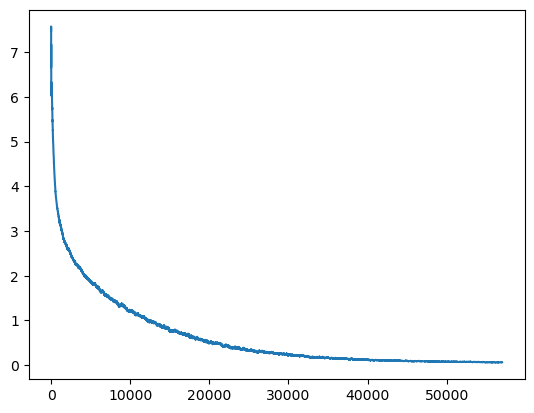

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['cuando herodes, que gobernaba en galilea, se entero de todo lo que estaba sucediendo, se quedo desconcertado, porque algunos decian que juan el bautista habia resucitado de entre los muertos.  mt']
["otta mushia herodes, chi sulaulashikai mma, naapa achikichi jesus sumaa supushua tu kasa naa'inrakat sainkuin mmakat.   jarai cheje eera nia  , musu naa'in nule'eru'u suka nnojoluin wanaawain sukujala tu wayuukoluirua nuchiki.  niataa juan owoutisaajuikai oso'iraain aa'in , musu waneeirua."]
["otta mushia herodes, chi sulaulashikai mma, naapapa suchiki tu alatakat numuin juan chi owoutisaajuikai, ponusu ma'i naa'in sutuma tu numakat paala soo'opunaa nakujain nuchiki."]


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x 2 jovyan users 4.0K Nov 25 20:18 .
4.0K drwxr-xr-x 8 jovyan users 4.0K Nov 25 20:18 ..
4.0K -rw-r--r-- 1 jovyan users  896 Nov 25 23:54 config.json
4.0K -rw-r--r-- 1 jovyan users  184 Nov 25 23:54 generation_config.json
2.3G -rw-r--r-- 1 jovyan users 2.3G Nov 25 23:54 pytorch_model.bin
4.7M -rw-r--r-- 1 jovyan users 4.7M Nov 25 23:54 sentencepiece.bpe.model
4.0K -rw-r--r-- 1 jovyan users 3.5K Nov 25 23:54 special_tokens_map.json
4.0K -rw-r--r-- 1 jovyan users  570 Nov 25 23:54 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='wayuu_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_wayuu_COMP_ND-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'wayuu_Cyrl'))

["anakaja muleka julujale jaa'in tu taa'inrakat joolu'u jupuleerua,"]


In [43]:
translate(t, 'spa_Latn', 'wayuu_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["anakaja muleka lotule pukuaippa sunain nnojoliin shiain ji'yataain joolu'u maa'utpunaa ka'i"]

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='wayuu_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'wayuu_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.wayuu)]
df_test['wayuu_translated'] = [translate(t, 'spa_Latn', 'wayuu_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))
print(chrf_calc.corpus_score(df_test['wayuu_translated'].tolist(), [df_test['wayuu'].tolist()]))

BLEU = 8.72 46.4/19.3/11.7/8.4 (BP = 0.505 ratio = 0.594 hyp_len = 29109 ref_len = 48975)
chrF2++ = 24.51
BLEU = 8.23 47.0/21.0/12.6/8.9 (BP = 0.452 ratio = 0.557 hyp_len = 30020 ref_len = 53891)
chrF2++ = 28.95


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['wayuu', 'esp', 'wayuu_translated', 'esp_translated']]

wayuu  \
2260  jalia jia suulia ju'luwajiraain jukuaippa sumaa wayuu jieru otta wane jieru numaa wane toolo. ma...   
6242  nujununtaakalaka jesus nanainmuin na jieyuukana supula numuinjatuin namuin   jia jieyuukana jeru...   
6415  shiimain ma'i tu tamakat joolu'u jumuin  eesu supula sulatinnuin saainjala wayuu suulia nutuma m...   
2663  soto jumata jaa'in nuchiki chi wasenyotsekai jesucristo sunain nuputuin supushua tu kasa anasu n...   
7813  otta tayakai, chi aluwataashikai, meechi taya namuin  'tamusu paala tu shiimuinkat jumuin  saa'u...   
3065  je paala sumaiwa, akujunusu suchiki kasa anasu nutuma maleiwa numuin abraham wainma juya supulap...   
5793  je wane wayuu sa'akajee tu wayuukoluirua, mushi numuin jesus   ekirajuikalee, anashi muleka pulu...   
7879  otta mushia chi laulaashikai napuleerua na sacerdotekana, nusha'walaakalaka joolu'u sunain numui...   
8615                         jalia jia suulia mache'eyaajuin suulia nunuiki chi naa'inkai maleiwa jumuin.   
1157  naa'inreein joolu'u jose wane kasa wane'eya sumuin. nupureesajireein naya napushua so'u apunuin ...   

                                                                                                      esp  \
2260  huyan de la lujuria. cualquier otro pecado que la persona cometa queda fuera del cuerpo, pero el...   
6242  jesus se volvio hacia ellas y les dijo   mujeres de jerusalen, no lloren por mi  lloren, mas bie...   
6415  les aseguro que todo les sera perdonado a los seres humanos  tanto los pecados como las blasfemi...   
2663  ya conocen cual fue la generosidad de nuestro senor jesucristo  siendo rico como era, se hizo po...   
7813  y el rey les dira    les aseguro que todo lo que hayan hecho en favor del mas pequeno de mis her...   
3065  y la escritura misma, previendo que dios justificaria ver nota rm NUM. a todas las naciones medi...   
5793  uno que estaba entre la gente dijo jesus   maestro, dile a mi hermano que reparta la herencia co...   
7879  levantandose entonces el sumo sacerdote, dijo jesus    no tienes nada que alegar a lo que estos ...   
8615                                                                   no apaguen la fuerza del espiritu,   
1157                                                                  jose los encerro durante tres dias.   

                                                                                         wayuu_translated  \
2260  jalia jia suulia kachiiruain jaa'in a'luwajirawaa akuaippaa sumaa wayuu jieru otta wane jieru nu...   
6242  nujununujaakalaka jesus sunain numuin namuin tu wayuukoluirua yaa jerusalenje'ewaliikana, nnojo ...   
6415  shiimuin tu tamakat jumuin atujasu alatinnaa saainjala wayuu suulia nutuma maleiwa, mayaasuje mo...   
2663  jutujaa aa'uchi chi wasenyotsekai jesucristo sunain kamaneein nia sumuin wayuu. mayaainje niain ...   
7813  otta mushia chi aluwataashikai, meechi taya namuin 'tamusu paala tu shiimuinkat jumuin saa'u kam...   
3065  je tu ashajunakat achiki sulu'u tu nuchikimaajatkat maleiwa sunain pansaain nunuiki sunain pansa...   
5793  otta wane wayuu sa'akajee tu wattakat saalin wayuu ekirajuikalee, pusakira tamuin wane tawala su...   
7879  otta mushia chi laulaashikai napuleerua na sacerdotekana, nusha'walaakalaka sunain numuin jesus ...   
8615                                   je nnojo juu'ulaain suulia a'yatawaa numuin chi naa'inkai maleiwa.   
1157                                  je jose, ni'itaain joo naya sulu'u tu kaatsetkat so'u apunuin ka'i.   

                                                                                           esp_translated  
2260  evita las inmoralidades sexuales, pues esos son los desordenados apetitos que hay en el cuerpo d...  
6242  y, dirigiendose a ellas, les dijo hijas de jerusalen, no llores por mi. llores por ustedes mismo...  
6415                          por eso les digo que dios puede ocultar tanto el pecado como las calumnias.  
2663  y buen animo unos a otros, como jesucristo, el senor, ya ha di